In [1]:
from niche_fit import *
from niche_calib import *
from read_flasher_logs import *

from utils import *
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
counter = 'noether'
calib_directory = Path('calib') / counter
nraws = []
for file in calib_directory.iterdir():
    if file.name.endswith('.bin'):
        nraws.extend(read_niche_file(file))

In [3]:
calibs = np.array([CalibPulse(r) for r in nraws],dtype='O')
pulse_levels = np.array([c.pulse_mean for c in calibs])
calibs = calibs[pulse_levels>40.]
pulse_levels = pulse_levels[pulse_levels>40.]

In [4]:
pulse_var = np.array([np.var(c.pulse) for c in calibs])
trigtimes = np.array([c.trigtime() for c in calibs])

In [5]:
amps = np.array(run_multiprocessing(ampl_at_time,trigtimes))

|████████████████████████████████████████| 5299/5299 [100%] in 1.4s (3776.86/s) 


In [6]:
amps

array([ 20.,  20.,  20., ..., 120.,   0.,  80.])

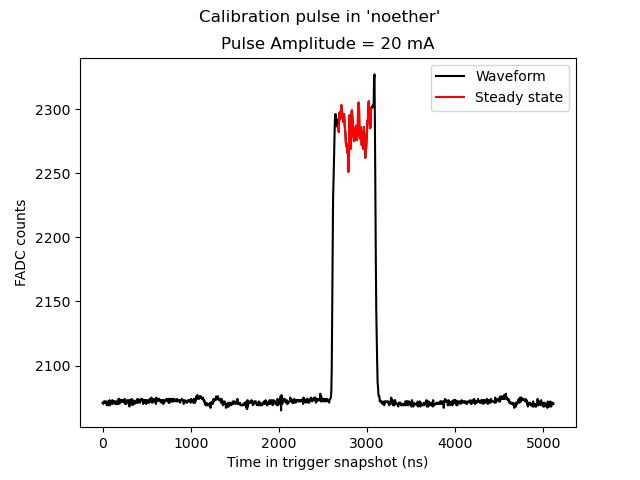

In [7]:
plt.figure()
ind = 5
c=calibs[ind]
plt.plot(5.*np.arange(len(c.waveform)),c.waveform, color = 'k', label='Waveform')
plt.plot(5.*np.arange(len(c.waveform))[c.start_rise:c.end_fall],c.waveform[c.start_rise:c.end_fall], color = 'r', label='Steady state')
plt.title(f'Pulse Amplitude = {amps[ind]:.0f} mA')
plt.suptitle(f"Calibration pulse in '{counter}'")
plt.xlabel('Time in trigger snapshot (ns)')
plt.ylabel('FADC counts')
plt.legend()

In [8]:
trigtimes[0]

numpy.datetime64('2024-04-13T06:17:23.787107080')

In [9]:
log_file = find_log_file(trigtimes[0])

In [10]:
log_file

PosixPath('calib/logs/log_04-13-24_00:09:04.txt')

In [11]:
ts,ampls=read_log_file(log_file)

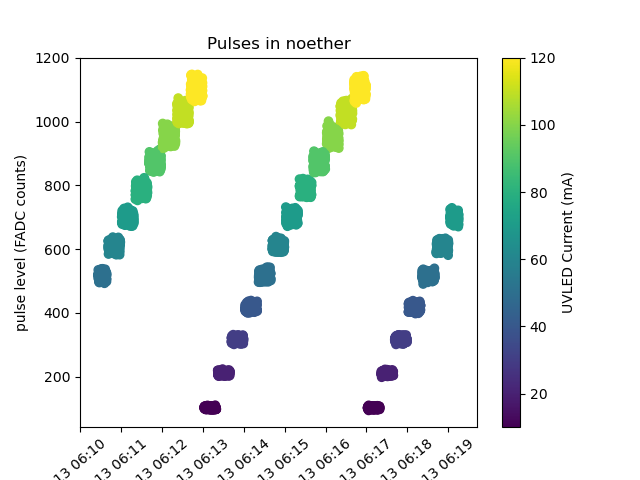

In [12]:
plt.figure()
plt.scatter(trigtimes[amps>0], pulse_levels[amps>0], c = amps[amps>0])
plt.colorbar(label='UVLED Current (mA)')
plt.xlabel('time')
plt.ylabel('pulse level (FADC counts)')
plt.title(f'Pulses in {counter}')
ax=plt.gca()
ax.xaxis.set_tick_params(rotation=40)
# plt.vlines(ts+np.timedelta64(5, 's'),0,250)
# plt.xlim((np.datetime64('2024-04-13T04:00:00'),np.datetime64('2024-04-13T04:10:39')))

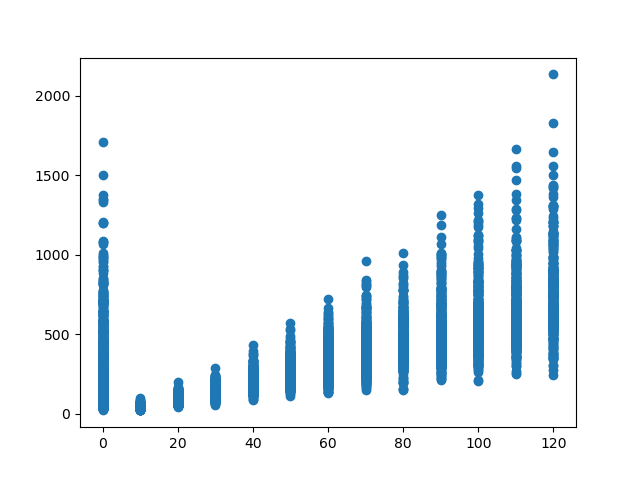

In [13]:
plt.figure()
plt.scatter(amps,pulse_var)

In [14]:
ampset = np.arange(1,13) * 10.
# mean_vars = []
# for amp in ampset:
#     plt.figure()
#     h,bins,_ = plt.hist(pulse_var[amps==amp], bins = 30)
#     mean = pulse_var[amps==amp].mean()
#     plt.vlines(mean,0,h.max(),color='k',label='mean')
#     plt.title(f'Pulse Amplitude = {amp}')
#     plt.xlabel('Pulse Variance')
#     mean_vars.append(mean)
    

Text(0, 0.5, 'count')

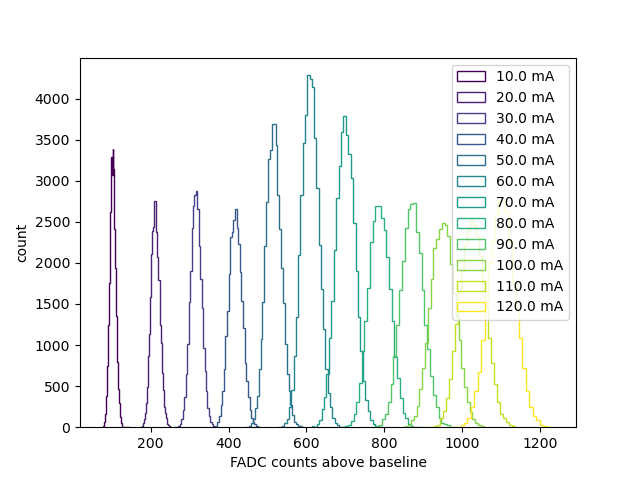

In [15]:
var = []
means = []
colors = plt.cm.viridis((ampset-ampset.min())/(ampset-ampset.min()).max())
plt.figure()
for i,amp in enumerate(ampset):
    pulse_fadc_array = []
    for c in calibs[amps==amp]:
        pulse_fadc_array.extend(c.pulse)
    pulse_fadc_array = np.array(pulse_fadc_array)
    var.append(np.var(pulse_fadc_array))
    means.append(np.mean(pulse_fadc_array))
    plt.hist(pulse_fadc_array, bins = 30, label = f'{amp} mA', histtype='step', color = colors[i])
    # plt.vlines(np.mean(pulse_fadc_array),0,4000)
plt.legend()
plt.xlabel('FADC counts above baseline')
plt.ylabel('count')

Text(0, 0.5, 'mean^2/variance')

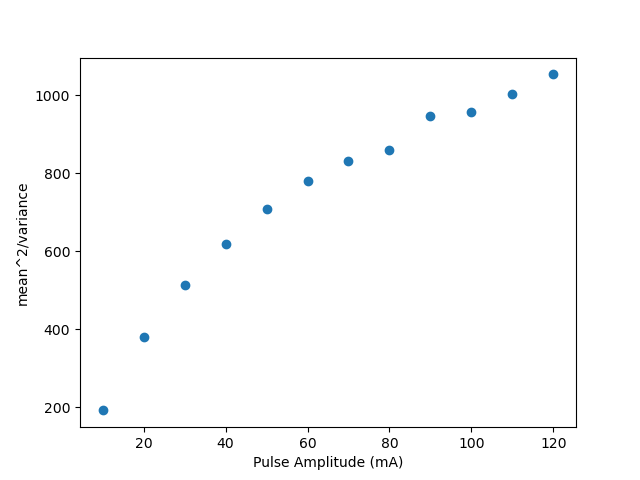

In [16]:
plt.figure()
means = np.array(means)
var = np.array(var)
plt.scatter(ampset,means**2/var)
plt.xlabel('Pulse Amplitude (mA)')
plt.ylabel('mean^2/variance')

In [17]:
np.var([c.waveform[:470] for c in calibs])

3.442842918374004

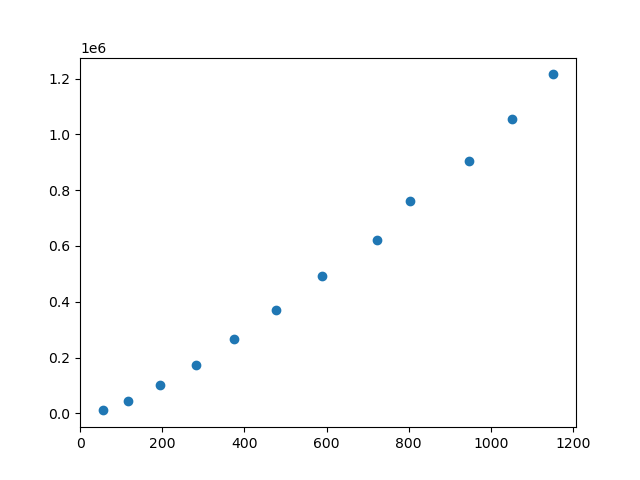

In [18]:
plt.figure()
means = np.array(means)
var = np.array(var)
plt.scatter(var,means**2)
# plt.hlines(baseline_var,0,1.3e6)
# plt.xlabel('Average sample value')
# plt.ylabel('mean^2/variance')

(array([ 1.,  2.,  6.,  6.,  8., 17., 13., 21., 10., 18., 15., 21., 10.,
        18., 20., 15., 25., 19., 25., 19., 12., 11.,  8., 12.,  6.,  4.,
         7.,  5.,  3.,  3.]),
 array([80460.664     , 80688.04266667, 80915.42133333, 81142.8       ,
        81370.17866667, 81597.55733333, 81824.936     , 82052.31466667,
        82279.69333333, 82507.072     , 82734.45066667, 82961.82933333,
        83189.208     , 83416.58666667, 83643.96533333, 83871.344     ,
        84098.72266667, 84326.10133333, 84553.48      , 84780.85866667,
        85008.23733333, 85235.616     , 85462.99466667, 85690.37333333,
        85917.752     , 86145.13066667, 86372.50933333, 86599.888     ,
        86827.26666667, 87054.64533333, 87282.024     ]),
 <BarContainer object of 30 artists>)

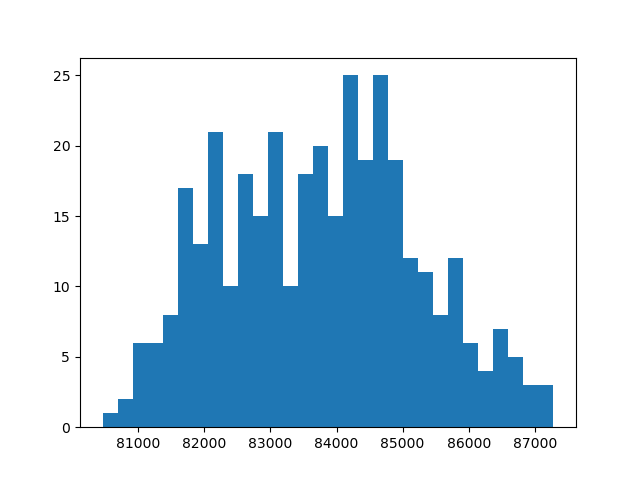

In [19]:
amp = 120.
PAs = np.array([c.pulse.sum() for c in calibs[amps==amp]])
plt.figure()
plt.hist(PAs,bins=30)

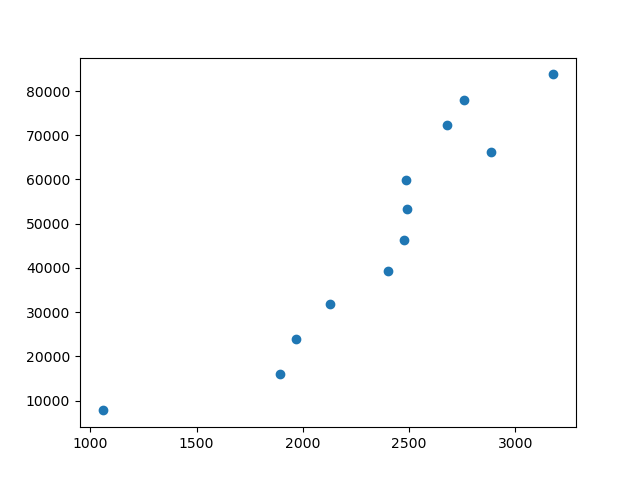

In [20]:
ns = []
var = []
mean2 = []
meanpa = []
for amp in ampset:
    PAs = np.array([c.pulse.sum() for c in calibs[amps==amp]])
    ns.append(PAs.mean()**2/np.var(PAs))
    var.append(np.var(PAs))
    mean2.append(PAs.mean()**2)
    meanpa.append(PAs.mean())
    

plt.figure()
plt.scatter(ns,meanpa)

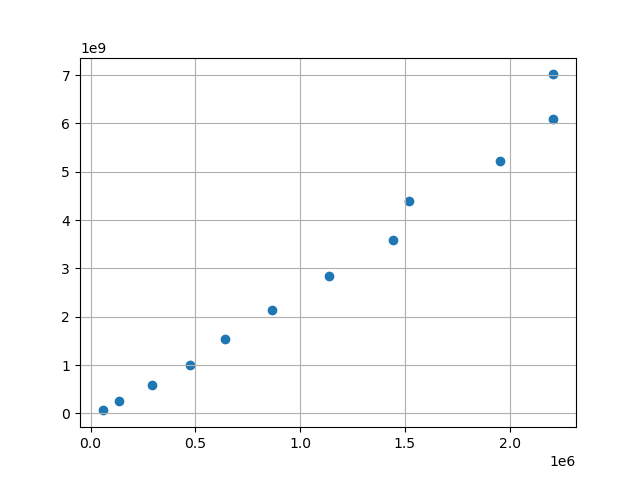

In [21]:
plt.figure()
plt.scatter(var,mean2)
plt.grid()

In [22]:
trigtimes[amps>0]

array(['2024-04-13T06:17:23.787107080', '2024-04-13T06:17:23.887105890',
       '2024-04-13T06:17:23.987104695', ...,
       '2024-04-13T06:11:34.991274155', '2024-04-13T06:12:58.690273635',
       '2024-04-13T06:11:35.091272215'], dtype='datetime64[ns]')